In [ ]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import random
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras import layers
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from random import sample
from tqdm import tqdm
import seaborn as sns

Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

base_dir = "/content/drive/My Drive/PSDA/Assignment 3/" 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
df = pd.read_csv(base_dir + "Csv_data/all.csv", index_col=[0])

# Data exploration

In [ ]:
df

,left_acc_x,left_acc_y,left_acc_z,left_gyr_x,left_gyr_y,left_gyr_z,left_quat_w,left_quat_x,left_quat_y,left_quat_z,hip_acc_x,hip_acc_y,hip_acc_z,hip_gyr_x,hip_gyr_y,hip_gyr_z,hip_quat_w,hip_quat_x,hip_quat_y,hip_quat_z,right_acc_x,right_acc_y,right_acc_z,right_gyr_x,right_gyr_y,right_gyr_z,right_quat_w,right_quat_x,right_quat_y,right_quat_z,rtls_accuracy,rtls_accuracy_radius,rtls_mapped_position,rtls_state,rtls_x_filtered,rtls_x_unfiltered,rtls_y_filtered,rtls_y_unfiltered,rtls_z_filtered,rtls_z_unfiltered,label,id
2020-05-26 08:04:14.120,-0.219889,-0.481445,-0.724284,-2.234163,-1.024139,-0.543110,0.669796,0.350221,-0.594804,0.273585,-0.058105,0.763346,0.311686,0.241934,0.023413,0.066337,0.061358,0.808043,0.094697,-0.578216,0.235677,1.509928,-0.299642,-1.073449,-0.692456,1.059259,0.011814,-0.673664,0.358302,0.645980,0.0,0.0,-1.0,2.0,3.208845,3.208845,1.387482,1.387482,2.668098,2.668098,0.0,0
2020-05-26 08:04:14.140,0.157715,-0.911621,0.000000,-1.587824,-0.408662,-0.025541,0.682057,0.343657,-0.585584,0.271586,-0.044922,0.843750,0.312988,-0.085138,-0.105358,0.026606,0.062371,0.807224,0.094346,-0.579308,0.500488,0.030273,-0.340332,3.420420,-1.994358,-0.268185,0.012550,-0.647711,0.342284,0.680294,0.0,0.0,-1.0,2.0,3.208845,3.208845,1.387482,1.387482,2.668098,2.668098,0.0,0
2020-05-26 08:04:14.160,0.078125,-0.699219,0.000488,0.219230,0.220295,-0.110679,0.685126,0.340926,-0.582634,0.273695,-0.019043,0.946777,0.304688,-0.040441,0.064918,-0.088331,0.062654,0.807496,0.094727,-0.578837,0.210449,0.408691,-0.040527,2.470067,-1.248336,-0.666205,0.012896,-0.637094,0.334999,0.694061,0.0,0.0,-1.0,2.0,3.208845,3.208845,1.387482,1.387482,2.668098,2.668098,0.0,0
2020-05-26 08:04:14.180,0.116211,-0.741211,-0.258626,0.784689,0.472871,-0.222068,0.678902,0.349042,-0.586143,0.271380,-0.006348,0.965658,0.335286,-0.013480,0.140123,-0.077688,0.061188,0.807621,0.094754,-0.578814,0.159017,0.625814,0.039551,1.442735,-0.385604,-0.808102,0.022569,-0.624732,0.322383,0.710798,0.0,0.0,-1.0,2.0,3.208845,3.208845,1.387482,1.387482,2.668098,2.668098,0.0,0
2020-05-26 08:04:14.200,-0.110840,-1.037109,-0.567871,2.065661,1.073803,-0.128771,0.663965,0.362933,-0.595742,0.269003,0.004395,0.996582,0.363281,-0.021285,0.090459,-0.041505,0.059158,0.807807,0.094314,-0.578838,0.070801,0.552246,-0.176758,0.467195,0.584260,-0.774756,0.034869,-0.623037,0.319589,0.713050,0.0,0.0,-1.0,2.0,3.208845,3.208845,1.387482,1.387482,2.668098,2.668098,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-26 18:07:01.200,-0.580078,-0.984538,-0.343913,0.482094,-4.256191,-1.744975,0.342945,-0.490375,-0.273338,-0.752820,-0.029785,0.969238,0.284668,-0.008514,-0.098973,-0.035119,0.613283,-0.094937,0.779998,0.080464,-0.331706,1.053711,0.552572,-1.477499,-4.178148,-0.252576,0.047951,-0.634551,0.370333,0.676346,0.0,0.0,-1.0,1.0,3.057509,3.064015,1.384443,1.362724,2.326005,2.519745,0.0,29
2020-05-26 18:07:01.220,-0.625000,-0.854980,-0.353027,-0.045762,-4.401635,-1.484594,0.298254,-0.504422,-0.239510,-0.774104,-0.012207,0.951660,0.299316,0.009578,-0.003193,-0.021285,0.613191,-0.095385,0.779993,0.080681,-0.278320,1.057129,0.339844,-1.216409,-4.609159,-0.363965,0.028337,-0.642108,0.349333,0.681807,0.0,0.0,-1.0,1.0,3.057509,3.064015,1.384443,1.362723,2.326005,2.519745,0.0,29
2020-05-26 18:07:01.240,-0.705078,-0.825195,-0.502441,0.068110,-4.489966,-1.493108,0.280677,-0.509885,-0.226557,-0.780615,-0.011719,0.942139,0.291504,0.021817,-0.021285,-0.019156,0.613178,-0.095742,0.779982,0.080466,-0.280029,1.195068,0.247803,-1.249932,-4.857656,-0.304901,0.003986,0.652462,-0.314827,-0.689319,0.0,0.0,-1.0,1.0,3.057509,3.064015,1.384443,1.362723,2.326005,2.519745,0.0,29
2020-05-26 18:07:01.260,-2.483236,1.871094,-4.249674,5.843660,-0.360063,-2.737187,0.248654,-0.555116,-0.236941,-0.756464,0.017090,0.946777,0.257812,0.004257,-0.061725,-0.006385,0.613259,-0.096295,0.779801,0.080943,-0.340007

In [ ]:
# What is visualized， What information can be obtained

In [ ]:
df.columns

Index(['left_acc_x', 'left_acc_y', 'left_acc_z', 'left_gyr_x', 'left_gyr_y',
       'left_gyr_z', 'left_quat_w', 'left_quat_x', 'left_quat_y',
       'left_quat_z', 'hip_acc_x', 'hip_acc_y', 'hip_acc_z', 'hip_gyr_x',
       'hip_gyr_y', 'hip_gyr_z', 'hip_quat_w', 'hip_quat_x', 'hip_quat_y',
       'hip_quat_z', 'right_acc_x', 'right_acc_y', 'right_acc_z',
       'right_gyr_x', 'right_gyr_y', 'right_gyr_z', 'right_quat_w',
       'right_quat_x', 'right_quat_y', 'right_quat_z', 'rtls_accuracy',
       'rtls_accuracy_radius', 'rtls_mapped_position', 'rtls_state',
       'rtls_x_filtered', 'rtls_x_unfiltered', 'rtls_y_filtered',
       'rtls_y_unfiltered', 'rtls_z_filtered', 'rtls_z_unfiltered', 'label',
       'id'],
      dtype='object')

In [ ]:
df.describe()

,left_acc_x,left_acc_y,left_acc_z,left_gyr_x,left_gyr_y,left_gyr_z,left_quat_w,left_quat_x,left_quat_y,left_quat_z,hip_acc_x,hip_acc_y,hip_acc_z,hip_gyr_x,hip_gyr_y,hip_gyr_z,hip_quat_w,hip_quat_x,hip_quat_y,hip_quat_z,right_acc_x,right_acc_y,right_acc_z,right_gyr_x,right_gyr_y,right_gyr_z,right_quat_w,right_quat_x,right_quat_y,right_quat_z,rtls_accuracy,rtls_accuracy_radius,rtls_mapped_position,rtls_state,rtls_x_filtered,rtls_x_unfiltered,rtls_y_filtered,rtls_y_unfiltered,rtls_z_filtered,rtls_z_unfiltered,label,id
count,351868.000000,351868.000000,351868.000000,351868.000000,351868.000000,351868.000000,351868.000000,351868.000000,351868.000000,351868.000000,351868.000000,351868.000000,351868.000000,351868.000000,351868.000000,351868.000000,351868.000000,351868.000000,351868.000000,351868.000000,351868.000000,351868.000000,351868.000000,351868.000000,351868.000000,351868.000000,351868.000000,351868.000000,351868.000000,351868.000000,351868.0,351868.0,351868.0,351868.000000,351868.000000,351868.000000,351868.000000,351868.000000,351868.000000,351868.000000,351868.000000,351868.000000
mean,-0.527319,-0.559426,-0.014312,-0.039274,0.087593,-0.036834,0.421972,-0.293691,-0.232442,-0.108552,-0.040549,0.911987,0.332701,0.013295,-0.036250,0.020165,0.391152,0.077104,0.527297,-0.069738,-0.442018,0.653279,-0.092478,-0.067982,-0.051680,-0.034825,0.325941,-0.170907,0.182126,0.020293,0.0,0.0,-1.0,1.487970,3.313218,3.313717,1.850357,1.850805,2.531190,2.539312,0.350873,15.075568
std,0.341428,0.329065,0.480953,1.360470,0.903576,0.802429,0.239637,0.406744,0.416264,0.521397,0.205945,0.159032,0.241719,0.667200,1.170171,0.491166,0.196465,0.546218,0.256520,0.392726,0.365546,0.318615,0.487587,1.346868,1.024025,0.871911,0.233586,0.468591,0.359876,0.650961,0.0,0.0,0.0,0.498211,0.524505,0.529760,0.711739,0.712018,0.424519,0.469769,0.583663,8.679703
min,-9.215332,-7.193848,-12.952637,-15.427008,-7.309098,-7.976368,0.000002,-0.980049,-0.988580,-0.999371,-2.136719,-0.270182,-1.934570,-9.532265,-13.139279,-4.816328,0.000013,-0.950416,-0.455502,-0.740329,-8.809082,-6.711426,-11.820801,-20.129818,-8.554242,-6.861415,0.000008,-0.995618,-0.875151,-0.999003,0.0,0.0,-1.0,1.000000,0.328315,0.328315,-0.162217,-0.162217,-1.716529,-1.716529,0.000000,0.000000
25%,-0.777832,-0.785645,-0.347331,-0.493800,-0.217102,-0.320864,0.224733,-0.597156,-0.592414,-0.561130,-0.160645,0.837402,0.188232,-0.093652,-0.383121,-0.115468,0.228077,-0.400618,0.331239,-0.415255,-0.713135,0.468262,-0.453125,-0.598095,-0.440589,-0.367867,0.135027,-0.563140,-0.108806,-0.646399,0.0,0.0,-1.0,1.000000,2.996106,2.992357,1.321417,1.323523,2.361242,2.360642,0.000000,8.000000
50%,-0.544759,-0.604980,-0.045898,-0.003193,0.026606,-0.005853,0.417012,-0.371473,-0.274184,-0.155757,-0.042318,0.926514,0.321289,0.012771,-0.009578,0.000000,0.431903,0.143112,0.606945,-0.137689,-0.472453,0.690918,-0.115723,-0.021285,-0.022349,-0.000709,0.279581,-0.228782,0.184136,0.026592,0.0,0.0,-1.0,1.000000,3.206632,3.204917,1.540613,1.556719,2.548643,2.551503,0.000000,15.000000
75%,-0.308105,-0.347168,0.358154,0.442718,0.399084,0.261799,0.619473,-0.036283,0.107054,0.344606,0.083008,0.973307,0.469238,0.190496,0.251157,0.143316,0.559972,0.568165,0.742303,0.268060,-0.185059,0.868652,0.235840,0.518810,0.353678,0.308625,0.476981,0.195142,0.467865,0.665595,0.0,0.0,-1.0,2.000000,3.553942,3.564652,2.372483,2.374980,2.703654,2.704902,1.000000,23.000000
max,5.000000,5.875977,6.669922,17.144667,11.305264,6.479003,0.998054,0.981960,0.925102,0.997509,1.785645,3.759277,3.869629,9.799386,10.585848,6.514122,0.803583,0.955988,0.950910,0.755025,4.033691,8.623047,6.809082,13.992433,11.413815,9.111896,0.998055,0.991948,0.992002,0.998822,0.0,0.0,-1.0,2.000000,6.233178,6.233178,4.606568,4.606568,6.684289,6.684289,2.000000,29.000000


left_acc_x


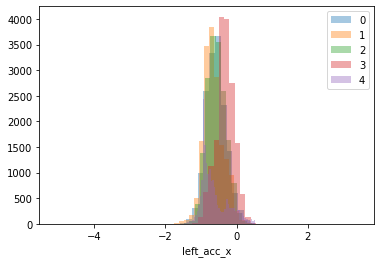

left_acc_y


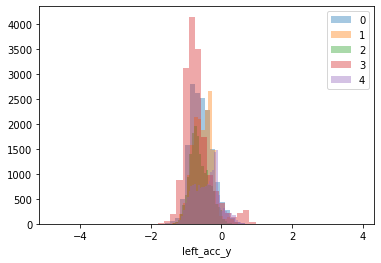

left_acc_z


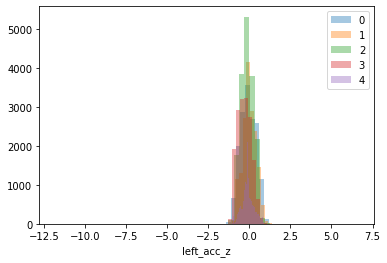

left_gyr_x


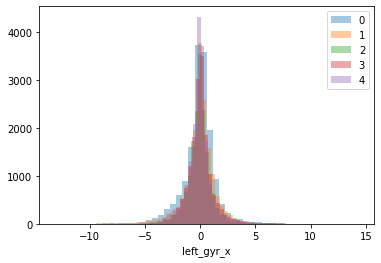

left_gyr_y


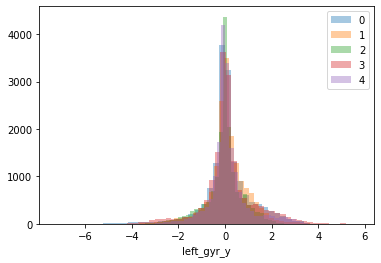

left_gyr_z


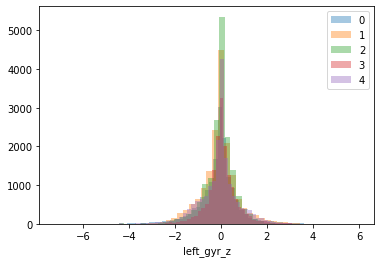

left_quat_w


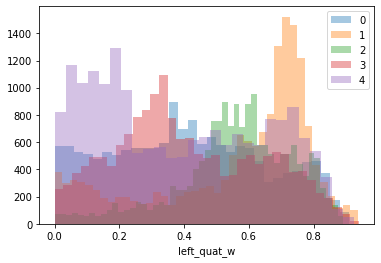

left_quat_x


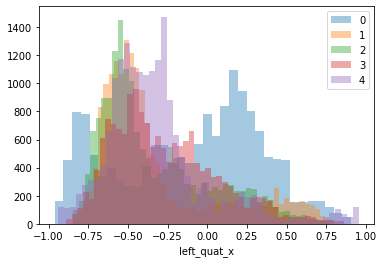

left_quat_y


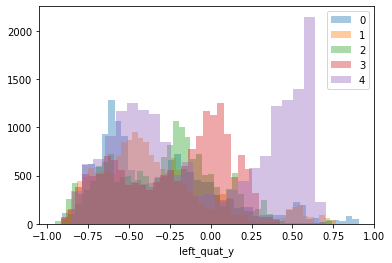

left_quat_z


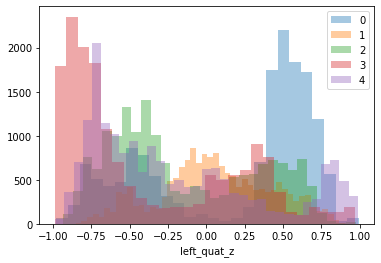

hip_acc_x


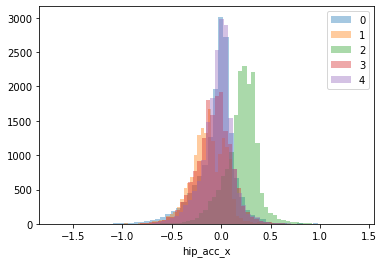

hip_acc_y


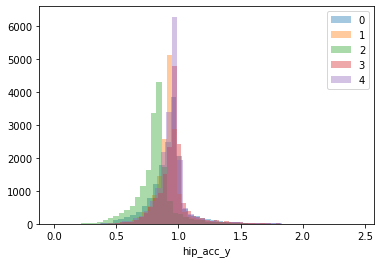

hip_acc_z


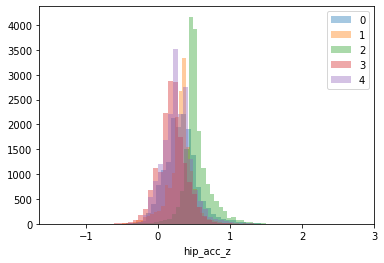

hip_gyr_x


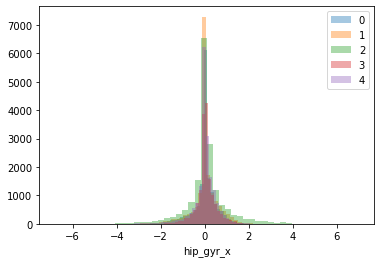

hip_gyr_y


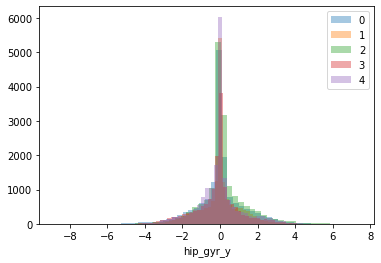

hip_gyr_z


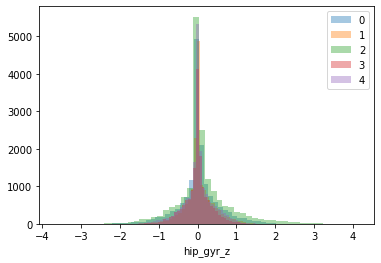

hip_quat_w


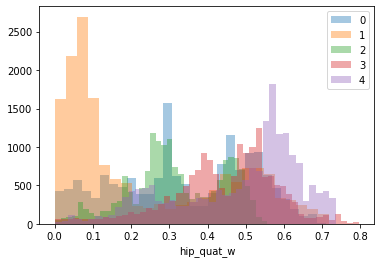

hip_quat_x


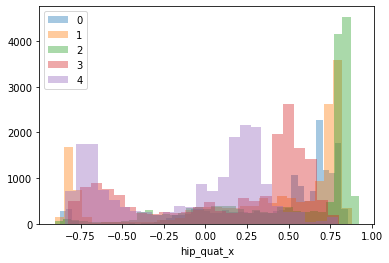

hip_quat_y


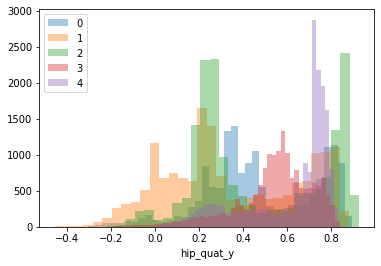

hip_quat_z


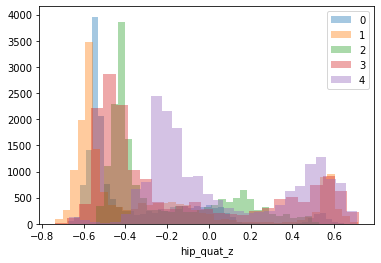

right_acc_x


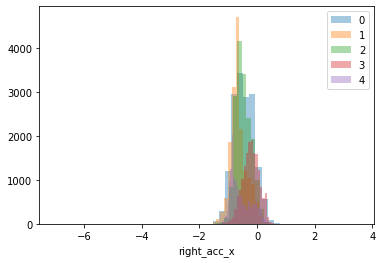

right_acc_y


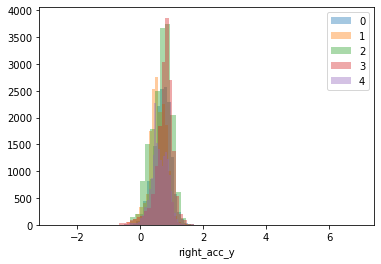

right_acc_z


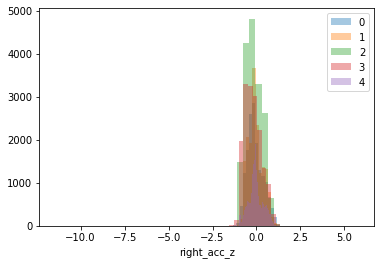

right_gyr_x


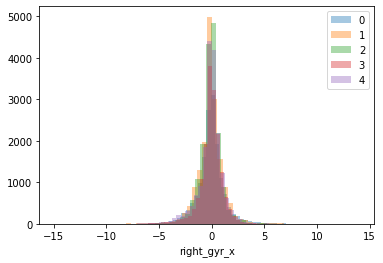

right_gyr_y


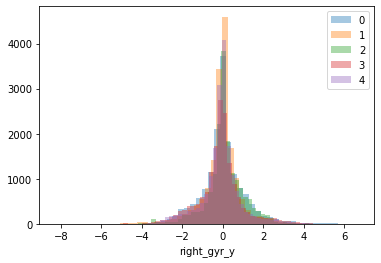

right_gyr_z


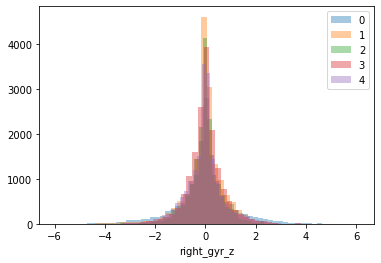

right_quat_w


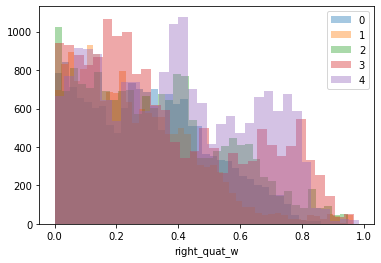

right_quat_x


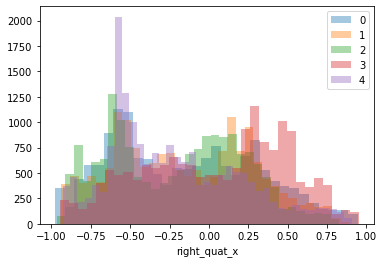

right_quat_y


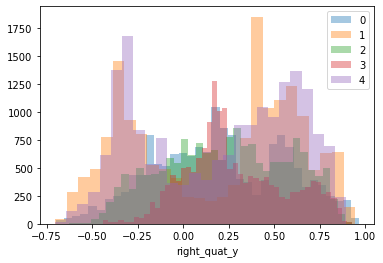

right_quat_z


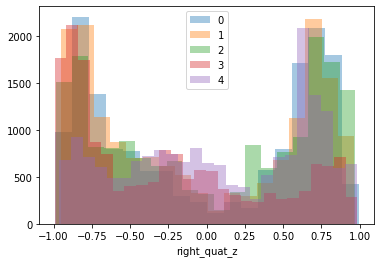

rtls_accuracy


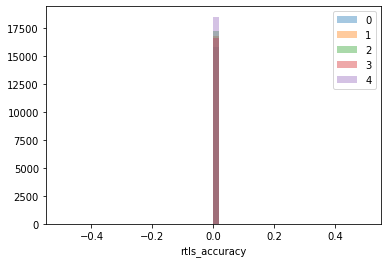

rtls_accuracy_radius


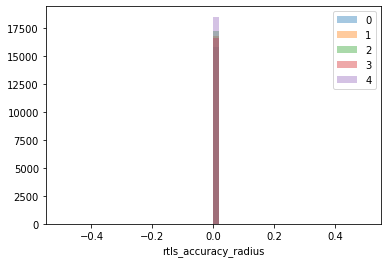

rtls_mapped_position


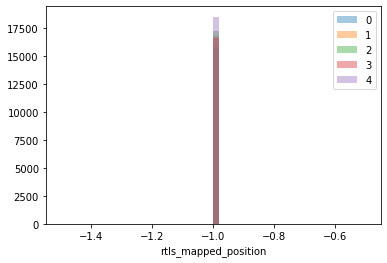

rtls_state


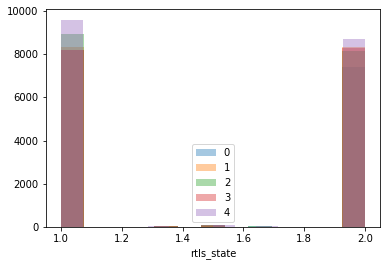

rtls_x_filtered


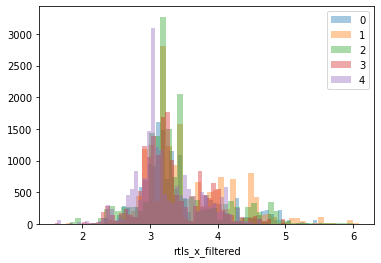

rtls_x_unfiltered


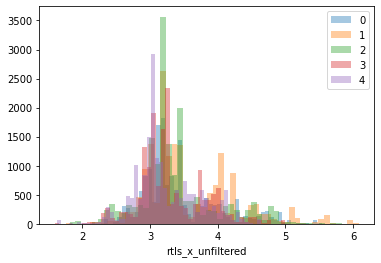

rtls_y_filtered


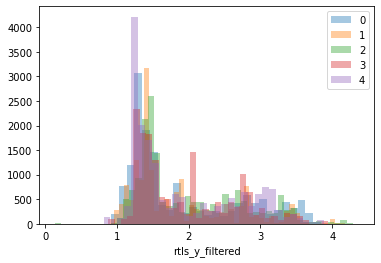

rtls_y_unfiltered


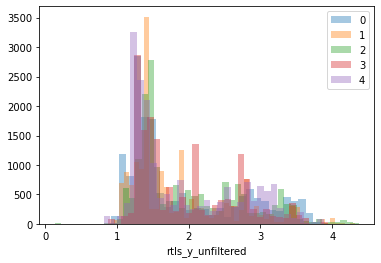

rtls_z_filtered


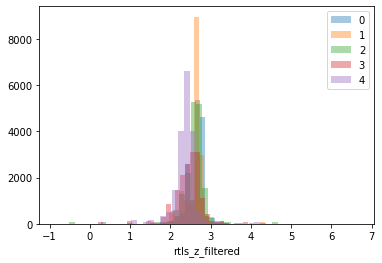

rtls_z_unfiltered


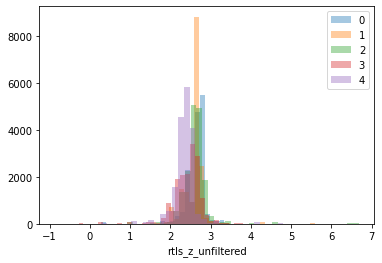

label


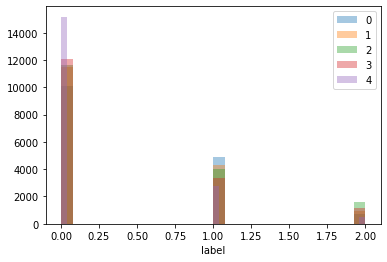

id


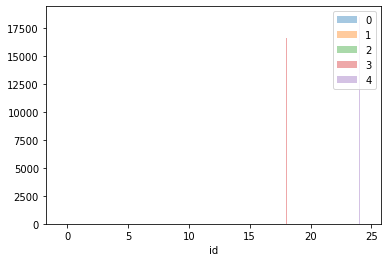

In [ ]:
for col in df.columns[:]:
  print(col)
  for index,id_ in enumerate([0,6,12,18,24]):
      a = df[df.id == id_]
      sns.distplot(a[col],  kde=False, label=str(index))
  plt.legend()
  plt.show()

# The distribution of sensor values is related to the person. ----- Preprocessing time series difference

We can identify that the data is highly unbalanced, with the vast majority of data entries labeled as label "0" (other).

Furthermore, by looking at the density plots of our different features, we can see that the distribution of the data is very different between the different participants, especially for the quaternion data.

Also, the distribution of the rtls data is different to the gyroscope and acc. data, having several peaks instead of just one. This motivates us to handle the data of the different sensors seperately (See Notebook about Splitnet).

Let's explore now the time sequence a little more in detail.

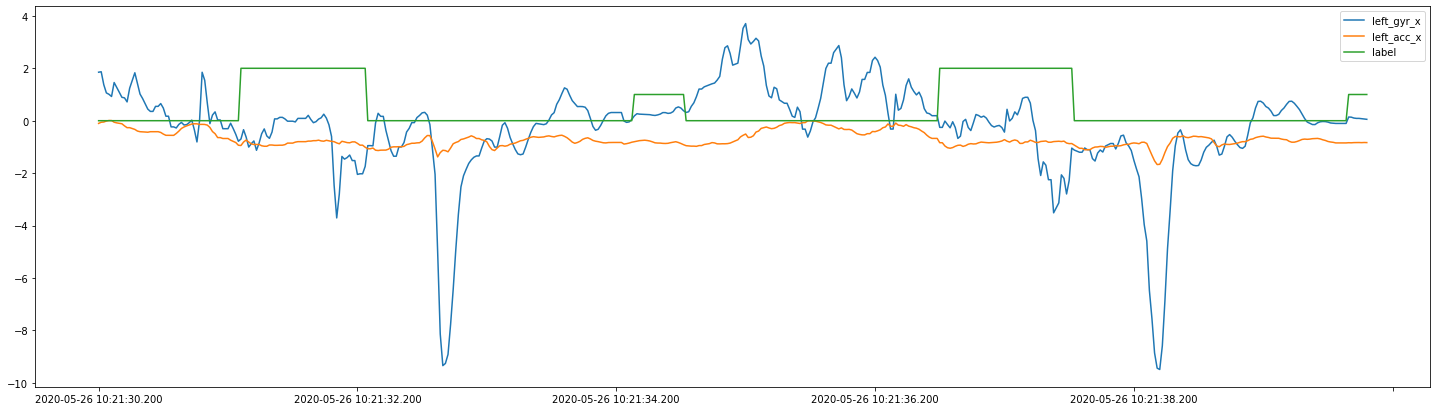

In [7]:
df['2020-05-26 10:21:30.200':'2020-05-26 10:21:40.000'].plot(y=['left_gyr_x', 'left_acc_x','label'], figsize=(25,7));

We can see that the gyroscope data is taking higher absolute values compared to the acceleration data. Additionally, this graph shows us that the significant movements in the data (in this case the gyroscope data) that might indicate the events (take and drop) occur during but also before and after the events. In the following, we will also take this insight into consideration when choosing our sliding windows for our models.